In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.signal

In [16]:
SF = 7 #Spreading Factor
Nsym = 2**SF
f0 = 2**13 # Base frequency
B = 2**11 # Bandwidth
Ts = 1 # Duration of a chirp
SNR = 0.025 # Signal to noise ratio
sn = 32 # Samples per period of highest frequency (>= 2 for nyquist)
fs = sn*(f0+B)*Ts # resolution
t = np.linspace(0, 1, fs) # sampling points
ww = fs*Nsym/B # window function width for short-time-fourier-transform

$x(t) = \text{sin} \left[ 2 \pi t \left( \frac k2 t + f_0 \right) \right]$

In [17]:
chirp = lambda f0, k, t: np.sin(2*np.pi*t*(f0 + k*t/2))
stitch = lambda x, c: np.concatenate((x[int(c*len(x)):], x[:int(c*len(x))])) # used for generating symbols from basechirp

In [18]:
butter_lowpass = lambda low, high, fs, order: scipy.signal.butter(order, [2*low/fs, 2*high/fs], btype='band', analog=False)
b, a = butter_lowpass(f0, f0+B, fs, 5)

In [19]:
baseChirp = chirp(f0, B, t)
downChirp = baseChirp[::-1] # inverse Chirp for de-chirping

timingOffsets = np.arange(0, Nsym)/(Nsym) # times where symbols are cut and stitched together
chirps = [stitch(baseChirp, t) for t in timingOffsets]

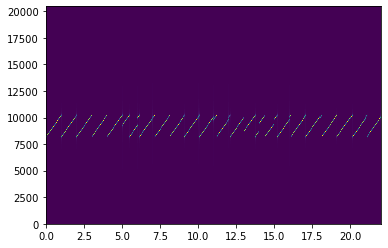

In [35]:
# ASCII-Werte für Nachricht generieren
seq = [ord(char) for char in "Computer Networks"]

# generate and transmit signal
preamble = np.concatenate([baseChirp for i in range(0, 5)]) 
message = np.concatenate([chirps[i] for i in seq])
tx = np.concatenate((preamble, message))
tx_f, tx_t, tx_Zxx = scipy.signal.stft(tx, fs, nperseg=ww)
frequencyRangeOfInterest = 4*len(tx_f)//sn
plt.pcolormesh(tx_t, tx_f[:frequencyRangeOfInterest], np.abs(tx_Zxx[:frequencyRangeOfInterest]))

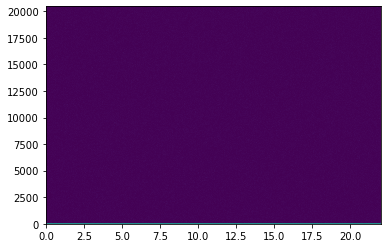

In [36]:
# Simulate signal manipulation during travel
noise = np.random.normal(-1/SNR, 1/SNR, len(tx))
rx = tx + noise
rx_f, rx_t, rx_Zxx = scipy.signal.stft(rx, fs, nperseg=ww)
frequencyRangeOfInterest = 4*len(tx_f)//sn
plt.pcolormesh(rx_t, rx_f[:frequencyRangeOfInterest], np.abs(rx_Zxx[:frequencyRangeOfInterest]))

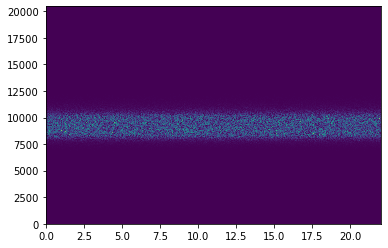

In [37]:
#demodulation preparation
lowpass = scipy.signal.lfilter(b, a, rx)
lp_f, lp_t, lp_Zxx = scipy.signal.stft(lowpass, fs, nperseg=ww)
frequencyRangeOfInterest = 4*len(tx_f)//sn
plt.pcolormesh(lp_t, lp_f[:frequencyRangeOfInterest], np.abs(lp_Zxx[:frequencyRangeOfInterest]))

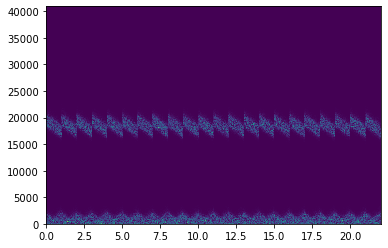

In [39]:
#dechirp
dechirped = lowpass * np.ndarray.flatten(np.repeat(np.array([downChirp]), len(tx)/fs, 0))
dc_f, dc_t, dc_Zxx = scipy.signal.stft(dechirped, fs, nperseg=ww)
frequencyRangeOfInterest = 8*len(tx_f)//sn
plt.pcolormesh(dc_t, dc_f[:frequencyRangeOfInterest], np.abs(dc_Zxx[:frequencyRangeOfInterest]))

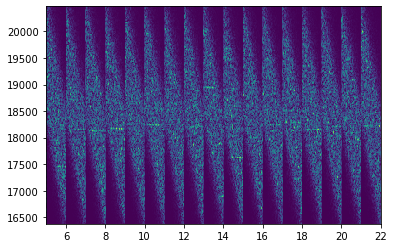

In [40]:
#remove preamble and excess frequencies
sx = int(2*len(preamble)//ww)
sy = np.argmin(np.abs(dc_f-2*(f0)))
ey = np.argmin(np.abs(dc_f-2*(f0+B)))
is_t = dc_t[sx:]
is_f = dc_f[sy:ey]
is_Zxx = dc_Zxx[sy:ey,sx:]
plt.pcolormesh(is_t, is_f, np.abs(is_Zxx))

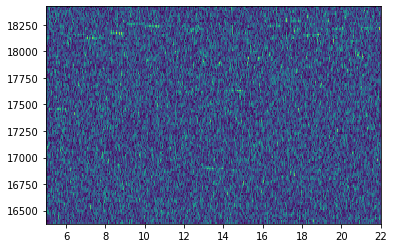

In [41]:
#unify low- and high-pitch parts of chirps.
un_t = is_t
un_f = is_f[:len(is_f)//2]
un_Zxx = np.add(is_Zxx[:len(un_f)], is_Zxx[len(un_f):2*len(un_f)])
plt.pcolormesh(un_t, un_f, np.abs(un_Zxx))

Computer Networks


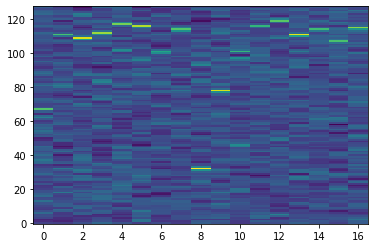

In [42]:
# seperate transmission into symbols
samplesPerSymbol = len(is_t)//len(seq)
splits = np.array([i*samplesPerSymbol for i in range(1, len(seq)+1)])
sy_t = splits
sy_f = un_f
sy_Zxx = np.split(un_Zxx, splits, axis=1)[:-1]

#sum over time
fin_t = np.arange(0, len(sy_t))
fin_f = np.arange(0, len(sy_f))
fin_Zxx = np.sum(np.abs(sy_Zxx), axis=2)
peaks = np.argmax(fin_Zxx, axis=1)

plt.pcolormesh(fin_t, fin_f, np.transpose(fin_Zxx))

read = str(''.join(map(chr, peaks)))
print(read)

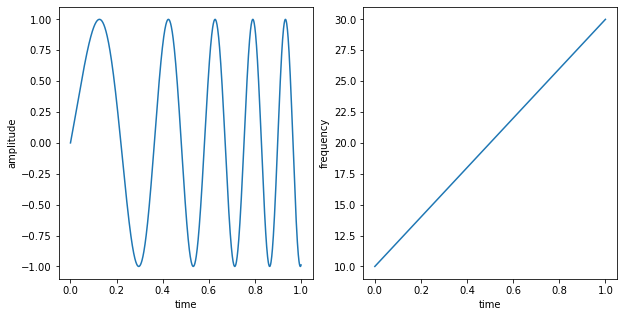

In [13]:
# chirp
N = 100
t = np.linspace(0, 1, 1000)
ft = np.linspace(10, 30, 1000)
yt = np.sin(ft*t)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.plot(t, yt)
ax1.set_xlabel('time')
ax1.set_ylabel('amplitude')
ax2.plot(t, ft)
ax2.set_xlabel('time')
ax2.set_ylabel('frequency')

fig.savefig('chirp.png', bbox_inches="tight")

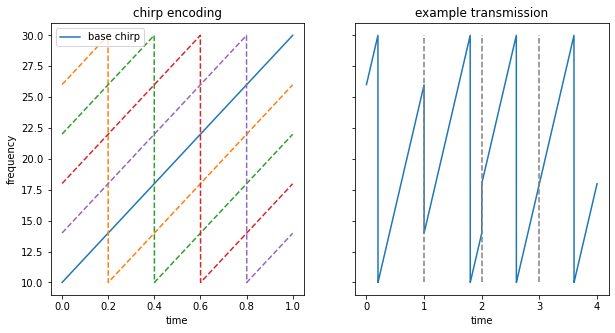

In [14]:
# chirp encoding
chirp = lambda base_chirp, n: np.concatenate((base_chirp[n:], base_chirp[:n]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax1.plot(t, chirp(ft, 0))
ax1.plot(t, chirp(ft, 800), linestyle="--")
ax1.plot(t, chirp(ft, 600), linestyle="--")
ax1.plot(t, chirp(ft, 400), linestyle="--")
ax1.plot(t, chirp(ft, 200), linestyle="--")
ax1.set_xlabel('time')
ax1.set_ylabel('frequency')
ax1.set_title('chirp encoding')
ax1.legend(['base chirp'])
ftrans = np.concatenate((chirp(ft, 800), chirp(ft, 200), chirp(ft, 400), chirp(ft, 400)))
strans = np.concatenate((np.sin(chirp(ft, 800)*t), np.sin(chirp(ft, 200)*t), np.sin(chirp(ft, 400)*t), np.sin(chirp(ft, 400)*t))) * 1 + 20
ax2.plot(np.linspace(0, 4, 4000), ftrans)
#ax2.plot(np.linspace(0, 4, 4000), strans)
ax2.plot((1, 1), (10, 30), linestyle="--", color='grey')
ax2.plot((2, 2), (10, 30), linestyle="--", color='grey')
ax2.plot((3, 3), (10, 30), linestyle="--", color='grey')
ax2.set_xlabel('time')
ax2.set_title('example transmission')

plt.savefig('encoding_and_transmission.png', bbox_inches="tight")

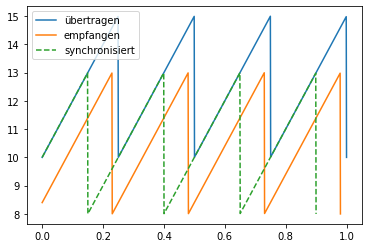

In [15]:
# chirp sync
tx = np.mod(ft, 5) + 10
rx = tx[20:] - 2

plt.plot(t, tx)
plt.plot(t[:-20], rx)
plt.plot(t[:-100], rx[80:], linestyle="--")
plt.legend(['übertragen', 'empfangen', 'synchronisiert'])
plt.savefig('synchronize.png', bbox_inches="tight")